# Example 1

## Anomaly detection in dynamic system behavior
In this example we demonstrate the capabilities of Learning Entropy on anomaly detection of simulated dynamic system controled with PID. As system approximator was chosen quadratic neural unit which is trained with Normalized Gradient Descent. System data with sample rate of 10 Hz have been generated for the following system with the equation defined as

$$ \ddot{\hat{y}}(t) +\big(0.3 + 0.03\cdot  \hat{y}(t) \big)\cdot\dot{ \hat{y}}(t) + 2\cdot \hat y(t)
=\Big(1 + 0.1\cdot sin\big( \hat y(t)\big)\Big)\cdot u(t)$$.

Where real output is always containing noise of low magnitudes.
$$y(t)=\hat y(t) +\epsilon$$

The PID regulator was configured as $K_{p}=5.4$, $K_{i}=2.9$ and $K_{d}=5.1$.

The provided example signal contains a total of 5 different anomalies. 
1. Anomaly is located on samples [150 - 190] and represents unusual drift of the output.
2. Anomaly is located on samples [365 - 410] and represents unusual change to $K_{p}$.
3. Anomaly is located on samples [500 - 525] and represents stuck sensor on constant value.
4. Anomaly is located on samples [615 - 620] and represents unusual system behavior to a step change.
5. Anomaly is located on samples [860 - 999] and represents slowly accumulated output change.

A showcase for sample usage in native python and JAX are shown. Then also the evaluation times for python and JAX accelerated Learning Entropy are compared.

In [1]:
# Import required libs
import math
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Get access to root folder of the notebook
sys.path.append("..")

# Pythonic AISLE
from src.aisle import aisle as py_aisle
from src.aisle import aisle_window as py_aisle_window

# JAX accelerated AISLE
from src.aisle_jax import aisle as jax_aisle
from src.aisle_jax import aisle_window as jax_aisle_window

%matplotlib widget

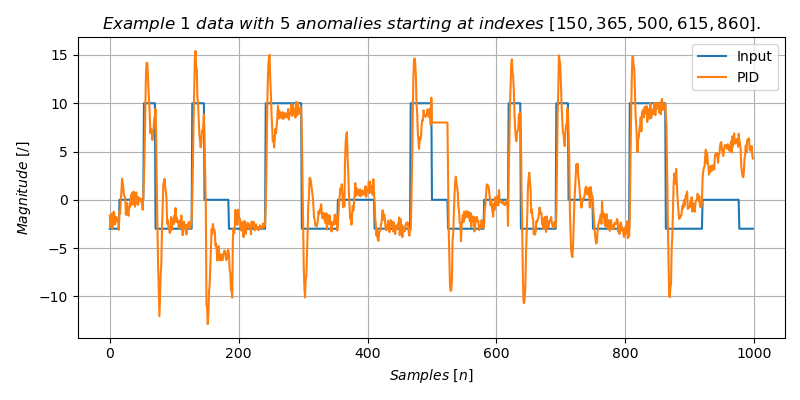

In [2]:
# Load and visualize input data
data = pd.read_csv("example_1_data.csv", header=0, index_col=0)

ax = data.plot(figsize=(8, 4))

# Set title and labels
ax.set_title(
    r"$Example \ 1 \ data \ with \ 5 \ anomalies \ starting \ at \ indexes \ [150,365,500,615,860].$"
)
ax.set_ylabel(r"$Magnitude \ [/]$")
ax.set_xlabel(r"$Samples \ [n]$")

plt.grid()
plt.tight_layout()
plt.show()

In [3]:
# Prepare data scaler and scale data for training
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

In [4]:
# Input data setup. The parameters nu and ny specify how many historic values from an input vector are be used
nu = 3  # Input
ny = 7  # PID
prediction_horizon = 1
N = data_normalized.shape[0]

X = np.ones((N, 1 + nu + ny))  # On the first position we will keep bias
y = np.zeros((N,))

# Generate X, y dynamically based on 'nu' and 'ny'
for k in range(max(nu, ny), N - prediction_horizon):
    X[k, 1 : nu + 1] = data_normalized["Input"].values[k - nu : k][::-1]
    X[k, 1 + nu :] = data_normalized["PID"].values[k - ny : k][::1]
    y[k] = data_normalized["PID"][k + prediction_horizon - 1]

X = X[max(nu, ny) : -prediction_horizon, :]
y = y[max(nu, ny) : -prediction_horizon]

In [5]:
# Train Quadratic Neural Unit (QNU)
mu = 0.1  # Learning rate
epochs = 2
r = 2  # QNU is second order polynom

# Initialize parameters
N = X.shape[0]
print(f"The total amount of samples: {N}.")
nw = X.shape[1]  # Get weights for QNU
nw = math.ceil(math.factorial(nw + r - 1) / math.factorial(r) / math.factorial(nw - 1))
w = np.random.randn(nw) / nw
print(f"Total amount of trainable weights {nw}.")

# Holders for adaptation values
e = np.zeros(N)
yn = np.zeros(N)
wall = np.zeros((N, nw))

# Training Quadratic Neural Unit
for epoch in range(epochs):
    for k in range(N):
        # Prepare polynomial input vector
        outer_product = np.outer(X[k], X[k])
        upper_triangle = np.triu_indices_from(outer_product)
        x = outer_product[upper_triangle]

        yn[k] = np.dot(w, x)
        e[k] = y[k] - yn[k]

        dyndw = x  # Gradient

        # Update weights
        # Uncomment the desired weight update rule

        # Pure Gradient Descent (GD)
        # dw = mu * e[k] * dyndw

        # GD with normalization
        dw = mu / (sum(x * x)) * e[k] * dyndw  # x0=1 => division by zero is avoided

        # GD with normalization and momentum
        # dw = 0.2 * mu / (sum(x * x)) * e[k] * dyndw + 0.8 * dw

        w = w + dw  # Update weights
        wall[k, :] = w  # Store weights for analysis

    epoch_error = np.mean(e**2)
    print(f"Epoch {epoch+1} Mean Squared Error: {epoch_error}")

The total amount of samples: 991.
Total amount of trainable weights 66.
Epoch 1 Mean Squared Error: 0.006871733638092324
Epoch 2 Mean Squared Error: 0.002309099019228459


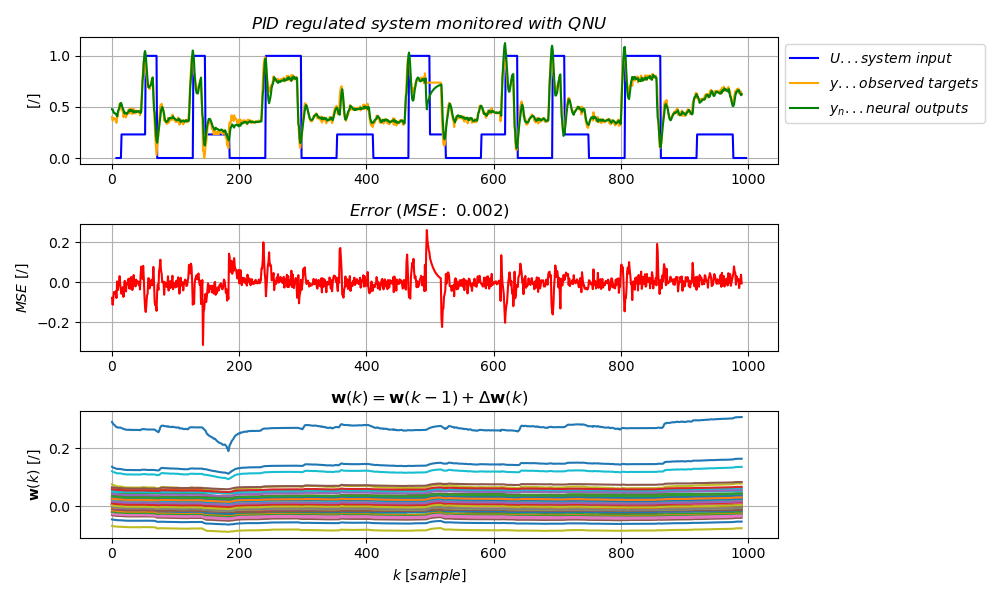

In [6]:
# Visualize model prediction
error = round(epoch_error, 3)

plt.figure(figsize=(10, 6))
# Plot observed target and neural output
ax1 = plt.subplot(311)
plt.title(r"$PID \ regulated \ system \ monitored \ with \ QNU$")
plt.plot(data_normalized["Input"][max(nu, ny) : -prediction_horizon], "b", label=r"$U ... system \ input$")
plt.plot(y, "orange", label=r"$y ... observed \ targets$")
plt.plot(yn, "g", label=r"$y_n ... neural \ outputs$")
plt.ylabel(r"$[/]$")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()

# Plot error between observed targets and neural outputs
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(e, "r", label=r"$e=y-y_n$")
plt.title(rf"$Error \ (MSE: \ {error})$")
plt.ylabel(r"$MSE \ [/]$")
# plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()

# Plot weights adaptation
ax3 = plt.subplot(313, sharex=ax1)
plt.plot(wall)
plt.title(r"$\mathbf{w}(k)=\mathbf{w}(k-1)+\Delta \mathbf{w}(k)$")
plt.ylabel(r"$\mathbf{w}(k) \ [/]$")
plt.xlabel(r"$k \ [sample]$")
plt.grid()

plt.tight_layout()
plt.show()

In [7]:
plt.savefig("../test_local/images/1_AIXLEX_QNU.svg")

## AISLE
In this part we will demonstrate usage of Learning Entropy on anomaly detection. As explained in [[1](https://www.researchgate.net/publication/257200647_Learning_Entropy_Multiscale_Measure_for_Incremental_Learning)] and further refined in [[2](https://www.researchgate.net/publication/331041954_Learning_Entropy_as_a_Learning-Based_Information_Concept)], Learning Entropy detects an anomaly by analyzing the weight updates of an neuron. The basic concept expects that once model is trained, the changes to weight updates should remain relatively similar over observed window of weights unless there is some novelty in data, which should be detected by Learning Entropy, as model needs more _energy_ to achieve new state.

### Execution time comparisson
For comparison of pythonic approach and JAX accelerated execution we provide naive time measurement approach within this notebook. Please do note, that once the code has been executed, next unchanged executions are usually cached and therefore invalid for any comparisons. As a fair comparison serves the window implementation, which is too big to remain cached.

#### Disclaimer
Measuring execution times within Jupyter Notebook always brings certain amount of error and is supposed to be taken as indicative and not absolute. Single AISLE evaluation places JAX accelerated LE to an disadvantege, as on its initial run the code has to be compiled. Repeated runs are then already accelerated. If evaluated data are too short or weight count is low, the compilation time of JAX takes usually longer than native implementation.


#### Sources
[1] I. Bukovsky, “Learning Entropy: Multiscale Measure for Incremental Learning,” Entropy, vol. 15, no. 10, pp. 4159–4187, Sep. 2013, doi: 10.3390/e15104159.

[2] I. Bukovsky, W. Kinsner, and N. Homma, “Learning Entropy as a Learning-Based Information Concept,” Entropy, vol. 21, no. 2, p. 166, Feb. 2019, doi: 10.3390/e21020166.

### AISLE - Single value retrieval

In [8]:
# Single AISLE value retrieval
oles = (1, 2, 3)
alphas = (4, 6, 7, 13)

# Python single Learning Entropy evaluation
py_aisle_time = time.time()
py_aisle_value = py_aisle(wall, alphas=alphas, oles=oles)
py_aisle_time = time.time() - py_aisle_time

# JAX accelerated single Learning Entropy evaluation
jax_aisle_time = time.time()
jax_aisle_value = jax_aisle(wall, alphas=alphas, oles=oles)
jax_aisle_time = time.time() - jax_aisle_time

msg = (
    f"Single LE evaluation ({py_aisle_value}) with pythonic approach took: {py_aisle_time:.6f} seconds.\n",
    f"Single LE evaluation ({jax_aisle_value}) with JAX aproach took: {jax_aisle_time:.6f} seconds.\n\n",
    "Single init evaluation with JAX is in general slower, as on its first run it has to compile parts of",
    " the code.\nRepeated usage is recommended.\n",
    "If reporting evaluation time is 0.000.., cache has been used and invalid time results are shown",
)
msg = "".join(text for text in msg)
print(msg)

Single LE evaluation ([0. 0. 0.]) with pythonic approach took: 0.001029 seconds.
Single LE evaluation ([[0. 0. 0.]]) with JAX aproach took: 0.716491 seconds.

Single init evaluation with JAX is in general slower, as on its first run it has to compile parts of the code.
Repeated usage is recommended.
If reporting evaluation time is 0.000.., cache has been used and invalid time results are shown


### AISLE - Moving window
Pythonic implementation of AISLE

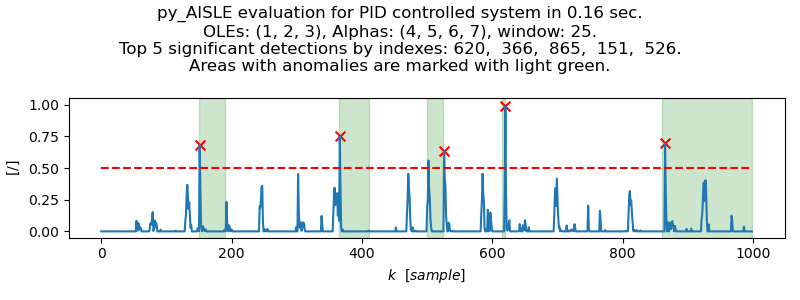

In [9]:
# AISLE setup
oles = (1, 2, 3)  # Order of LE
alphas = (4, 5, 6, 7)  # Sensitivity of evaluation
window = 25  # Window evaluated for each AISLE
threshold = 0.5  # Visual threshold (red dashed line)

# Sum, normalize and shift AISLE to correspond to original data
aisle_values = np.zeros(data.shape[0])
py_aisle_time = time.time()
py_aisle_values = py_aisle_window(window, wall, alphas, oles)
py_aisle_time = time.time() - py_aisle_time
aisle_values[max(nu, ny) : -prediction_horizon] = np.sum(py_aisle_values, axis=1) / len(oles)


# Sort all indices in descending order
all_sorted_indices = np.argsort(aisle_values)[::-1]

# Define the range within which indices are considered too close
proximity_range = 2

# Filter indices that are too close, prefering the one with the higher value
filtered_indices = []
for index in all_sorted_indices:
    if not any(abs(index - other_index) <= proximity_range for other_index in filtered_indices):
        filtered_indices.append(index)

N = 5  # Number of top indices to select
final_indices = filtered_indices[:N]

# Construct the plot title with the top N significant values
top_values_str = "indexes:" + ", ".join([f" {idx}" for idx in final_indices])
plot_title = (
    f"py_AISLE evaluation for PID controlled system in {py_aisle_time:.2f} sec.\n",
    f"OLEs: {oles}, Alphas: {alphas}, window: {window}.\n",
    f"Top 5 significant detections by {top_values_str}.\n",
    "Areas with anomalies are marked with light green.",
)
plot_title = "".join(text for text in plot_title)

roi_ranges = ((150, 190), (365, 410), (500, 525), (615, 620), (860, 999))

# Plotting
fig = plt.figure(figsize=(8, 3))
fig.suptitle(plot_title)
plt.plot(aisle_values, label="AISLE")
plt.hlines([0.5], 0, aisle_values.shape[0], colors="red", linestyles="dashed")
plt.ylabel(r"$[/]$")
plt.xlabel(r"$k~~[sample]$")

# Fill specified ROI ranges with green background
for start, end in roi_ranges:
    plt.fill_between(x=range(start, end + 1), y1=-0.05, y2=1.05, color="green", alpha=0.2)

# Places crosses on top indices
for index in final_indices:
    if index < len(aisle_values):
        plt.scatter(index, aisle_values[index], color="red", marker="x", s=50)

plt.ylim((-0.05, 1.05))
plt.tight_layout()
plt.show()

In [10]:
plt.savefig("../test_local/images/1_pyAISLE.svg")

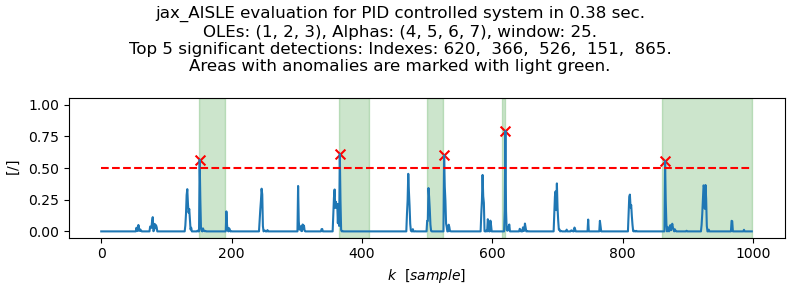

In [11]:
# AISLE setup
oles = (1, 2, 3)  # Order of LE
alphas = (4, 5, 6, 7)  # Sensitivity of evaluation
window = 25  # Window evaluated for each AISLE
threshold = 0.5  # Visual threshold (red dashed line)

# Sum, normalize and shift AISLE to correspond to original data
aisle_values = np.zeros(data.shape[0])
jax_aisle_time = time.time()
jax_aisle_values = jax_aisle_window(window, wall, alphas, oles)
jax_aisle_time = time.time() - jax_aisle_time
aisle_values[max(nu, ny) : -prediction_horizon] = np.sum(jax_aisle_values, axis=1) / len(oles)


# Sort all indices in descending order
all_sorted_indices = np.argsort(aisle_values)[::-1]

# Define the range within which indices are considered too close
proximity_range = 2

# Filter indices that are too close, prefering the one with the higher value
filtered_indices = []
for index in all_sorted_indices:
    if not any(abs(index - other_index) <= proximity_range for other_index in filtered_indices):
        filtered_indices.append(index)

N = 5  # Number of top indices to select
final_indices = filtered_indices[:N]

# Construct the plot title with the top N significant values
top_values_str = "Indexes:" + ", ".join([f" {idx}" for idx in final_indices])
plot_title = (
    f"jax_AISLE evaluation for PID controlled system in {jax_aisle_time:.2f} sec.\n",
    f"OLEs: {oles}, Alphas: {alphas}, window: {window}.\n",
    f"Top 5 significant detections: {top_values_str}.\n",
    "Areas with anomalies are marked with light green.",
)
plot_title = "".join(text for text in plot_title)

roi_ranges = ((150, 190), (365, 410), (500, 525), (615, 620), (860, 999))

# Plotting
fig = plt.figure(figsize=(8, 3))
fig.suptitle(plot_title)
plt.plot(aisle_values, label="AISLE")
plt.hlines([0.5], 0, aisle_values.shape[0], colors="red", linestyles="dashed")
plt.ylabel(r"$[/]$")
plt.xlabel(r"$k~~[sample]$")

# Fill specified ROI ranges with green background
for start, end in roi_ranges:
    plt.fill_between(x=range(start, end + 1), y1=-0.05, y2=1.05, color="green", alpha=0.2)

# Places crosses on top 5 indices
for index in final_indices:
    if index < len(aisle_values):
        plt.scatter(index, aisle_values[index], color="red", marker="x", s=50)

plt.ylim((-0.05, 1.05))
plt.tight_layout()
plt.show()

In [12]:
plt.savefig("../test_local/images/1_jaxAISLE.svg")

In [13]:
# AISLE with pythonic approach
%timeit -n100 -r25 py_aisle(wall, alphas=alphas, oles=oles)

335 µs ± 77.4 µs per loop (mean ± std. dev. of 25 runs, 100 loops each)


In [14]:
# AISLE with JAX accelerated approach
%timeit -n100 -r25 jax_aisle(wall, alphas=alphas, oles=oles)

The slowest run took 6.59 times longer than the fastest. This could mean that an intermediate result is being cached.
710 µs ± 523 µs per loop (mean ± std. dev. of 25 runs, 100 loops each)


In [15]:
# AISLE window evaluation with pythonic approach
%timeit -n5 -r10 py_aisle_window(window, wall, alphas, oles)

118 ms ± 7.5 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [16]:
# AISLE window evaluation with JAX accelerated approach
%timeit -n5 -r10 jax_aisle_window(window, wall, alphas, oles)

4.63 ms ± 915 µs per loop (mean ± std. dev. of 10 runs, 5 loops each)
